In thsi notebook I train on the original (random play generated) data set but this optimizing winning not predciting the score 

In [1]:
#standard modukles
import numpy as np
import random as random
import time
import pandas as pd
#using simpleguitk for display, is not needed for computer game
#likely not needed un this notebook 
import simpleguitk as simplegui
#foor plotting 
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
#for efficient saving and loading
import pickle
#skyjp game classes and functions
from skyjo_functions2 import *
#own functions for machine learning
from ml_functions2 import *
#for machine learning
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
#time logging
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
#again tensorflow problem work before with conda install cudatoolkit, is not needed after each restart? 
#no is not enough still does not work  


import seaborn as sns

#for confidence intervalls
from scipy.stats import beta
#for splitting
from sklearn.model_selection import train_test_split
#confusing matrix
from sklearn.metrics import confusion_matrix

2023-03-23 14:48:51.905102: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-23 14:48:51.905683: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Below I get the column names. 

In [2]:
names=['alpha','beta']
nature=['computer','computer']
levels=[0,0]
scores,turns,last_player,numeric=skyjo_round(names,nature,levels,0,True,True,True) 
print(numeric.shape)
#selected rows array
sel1=np.zeros((51))
#print the row to see whether it is what it should be 
#open card on pile
sel1[1]=1
#own card set
print(numeric[18:30,0])
sel1[18:30]=1
#other card set
print(numeric[30:42,0])
sel1[30:42]=1
#take open 
print(numeric[42])
sel1[42]=1
#discard
print(numeric[43])
sel1[43]=1
# discarded closed card
print(numeric[44])
sel1[44]=1
#id of selected player card
print(numeric[45])
sel1[45]=1
#numeric (number of open or 20 for closed) of selected player card
print(numeric[46])
sel1[46]=1
#score, differential is used as target for now both included in collection
print(numeric[49])
sel1[49]=1
print(numeric[50])
sel1[50]=1
print(sum(sel1))
print(numeric.shape)
# list of strings which will be pandas header
columns=['open_pile_card']
for i in range(12):
    columns.append('own_cards_'+str(i))
for i in range(12):
    columns.append('other_player_cards_'+str(i))    
columns.append('action_take_open')
columns.append('action_discard')
columns.append('discard_value')
columns.append('id_player_card')
columns.append('numeric_player_card')            
columns.append('score_self')
columns.append('score_other')
columns.append('round')
print(columns)
print(len(columns))
#create copy which to be used fields  score not
sel2=np.copy(sel1)
sel2[48:51]=0
np.savetxt("xgb_model1_column2.txt",sel2)
print(sum(sel2))
print(sum(sel1))
print(sel2)
print(sel1)
print(columns[0:30])
print(columns[28])

(51, 30)
[20 11 20 20 20 20 20 20 20 20 20  7]
[20 20  2 20 20 20 20 20 20 20 10 20]
[1 1 0 1 0 1 1 1 0 0 0 0 1 0 1 0 0 1 0 1 0 1 1 1 0 1 1 0 0 1]
[0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0]
[30 30  0 30  2 30 30 30  1  4 -2 10 30  5 30 12  2 30  7 30  5 30 30 30
  0 30 30 -1  5 30]
[ 8  7  7  3  2 10  8  1 10  2  0  3  4  5  5  1  3  5  3  1  6  1  1  3
  2  8  8  4  9  7]
[20 20 20 20 20 10  5 20 20  2 20  0 20 20 20  5 20  2  2 12 20  2 11 10
  2 20 10 20 20  9]
[36 58 36 58 36 58 36 58 36 58 36 58 36 58 36 58 36 58 36 58 36 58 36 58
 36 58 36 58 36 58]
[58 36 58 36 58 36 58 36 58 36 58 36 58 36 58 36 58 36 58 36 58 36 58 36
 58 36 58 36 58 36]
32.0
(51, 30)
['open_pile_card', 'own_cards_0', 'own_cards_1', 'own_cards_2', 'own_cards_3', 'own_cards_4', 'own_cards_5', 'own_cards_6', 'own_cards_7', 'own_cards_8', 'own_cards_9', 'own_cards_10', 'own_cards_11', 'other_player_cards_0', 'other_player_cards_1', 'other_player_cards_2', 'other_player_cards_3', 'other_player_c

In [3]:
#now withjthout taken card id for engering use 
sel1b=np.zeros((51))
#print the row to see whether it is what it should be 
#open card on pile
sel1b[1]=1
#own card set
print(numeric[18:30,0])
sel1b[18:30]=1
#other card set
print(numeric[30:42,0])
sel1b[30:42]=1
#take open 
print(numeric[42])
sel1b[42]=1
#discard
print(numeric[43])
sel1b[43]=1
# discarded closed card
print(numeric[44])
sel1b[44]=1
#id of selected player card not anymore used 
#print(numeric[45])
#sel1b[45]=1
#numeric (number of open or 20 for closed) of selected player card
print(numeric[46])
sel1b[46]=1
#score, differential is used as target for now both included in collection
print(numeric[49])
sel1b[49]=1
print(numeric[50])
sel1b[50]=1
print(sum(sel1b))
print(numeric.shape)
# list of strings which will be pandas header
columnsb=['open_pile_card']
for i in range(12):
    columnsb.append('own_cards_'+str(i))
for i in range(12):
    columnsb.append('other_player_cards_'+str(i))    
columnsb.append('action_take_open')
columnsb.append('action_discard')
columnsb.append('discard_value')
# not anymore used columnsb.append('id_player_card')
columnsb.append('numeric_player_card')            
columnsb.append('score_self')
columnsb.append('score_other')
columnsb.append('round')
print(columnsb)
print(len(columnsb))
#create copy which to be used fields  score not
sel2b=np.copy(sel1b)
sel2b[49:51]=0
np.savetxt("xgb_model2_column2.txt",sel2b)
print(sum(sel2b))
print(sum(sel1b))
print(sel2b)
print(sel1b)
print(columnsb[0:29])

[20 11 20 20 20 20 20 20 20 20 20  7]
[20 20  2 20 20 20 20 20 20 20 10 20]
[1 1 0 1 0 1 1 1 0 0 0 0 1 0 1 0 0 1 0 1 0 1 1 1 0 1 1 0 0 1]
[0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0]
[30 30  0 30  2 30 30 30  1  4 -2 10 30  5 30 12  2 30  7 30  5 30 30 30
  0 30 30 -1  5 30]
[20 20 20 20 20 10  5 20 20  2 20  0 20 20 20  5 20  2  2 12 20  2 11 10
  2 20 10 20 20  9]
[36 58 36 58 36 58 36 58 36 58 36 58 36 58 36 58 36 58 36 58 36 58 36 58
 36 58 36 58 36 58]
[58 36 58 36 58 36 58 36 58 36 58 36 58 36 58 36 58 36 58 36 58 36 58 36
 58 36 58 36 58 36]
31.0
(51, 30)
['open_pile_card', 'own_cards_0', 'own_cards_1', 'own_cards_2', 'own_cards_3', 'own_cards_4', 'own_cards_5', 'own_cards_6', 'own_cards_7', 'own_cards_8', 'own_cards_9', 'own_cards_10', 'own_cards_11', 'other_player_cards_0', 'other_player_cards_1', 'other_player_cards_2', 'other_player_cards_3', 'other_player_cards_4', 'other_player_cards_5', 'other_player_cards_6', 'other_player_cards_7', 'other_player_cards_8

Thus in total it are 30 features and 1 target. The target is currently still in two different columns. 

One round is clearly not enough to train, not only because of the length of typically 32 data collections (turns), but also because the data is similar in the different turns. 
Thus, the data from many rounds needs to be collected. 


Below a check I check the function which collected many rounds.

Now I join the five difefernt data sets.

In [4]:
df1=pd.read_pickle('level_rand_v2_0_600000_0.pkl')
df2=pd.read_pickle('level_rand_v2_0_600000_1.pkl')
df3=pd.read_pickle('level_rand_v2_0_600000_2.pkl')
df4=pd.read_pickle('level_rand_v2_0_600000_3.pkl')
df5=pd.read_pickle('level_rand_v2_0_600000_4.pkl')
df=pd.concat([df1,df2,df3,df4,df5],join='outer', ignore_index=True)
print(df1.shape,df.shape)
#free space
df1=0
df2=0
df3=0
df4=0
df5=0

(600000, 33) (3000000, 33)


Now I add the summarizing columns. 

In [12]:
weight_vec=np.array([5/150,10/150,15/150,10/150,10/150,10/150,10/150,10/150,10/150,10/150,10/150,10/150,10/150,10/150,10/150]) 
vals=np.array(range(-2,13))
print(vals)
av_value=np.dot(vals,weight_vec)
print(av_value)
df['own_n_closed']=df.loc[:,'own_cards_0':'own_cards_11'][df.loc[:,'own_cards_0':'own_cards_11']==20].count(axis=1)
#now n_open isstead because small n_vanished likely cases pron=blem in deep learning
df['own_n_open']=df.loc[:,'own_cards_0':'own_cards_11'][(df.loc[:,'own_cards_0':'own_cards_11']!=30) & (df.loc[:,'own_cards_0':'own_cards_11']!=20)].count(axis=1)
df['own_max']=df.loc[:,'own_cards_0':'own_cards_11'][(df.loc[:,'own_cards_0':'own_cards_11']!=20) & (df.loc[:,'own_cards_0':'own_cards_11']!=30)].max(axis=1)
df['own_sum']=df.loc[:,'own_cards_0':'own_cards_11'][(df.loc[:,'own_cards_0':'own_cards_11']!=20) & (df.loc[:,'own_cards_0':'own_cards_11']!=30)].sum(axis=1)
df['other_player_n_closed']=df.loc[:,'other_player_cards_0':'other_player_cards_11'][df.loc[:,'other_player_cards_0':'other_player_cards_11']==20].count(axis=1)
df['other_player_n_open']=df.loc[:,'other_player_cards_0':'other_player_cards_11'][(df.loc[:,'other_player_cards_0':'other_player_cards_11']!=20) & (df.loc[:,'other_player_cards_0':'other_player_cards_11']!=30)].count(axis=1)
df['other_player_max']=df.loc[:,'other_player_cards_0':'other_player_cards_11'][(df.loc[:,'other_player_cards_0':'other_player_cards_11']!=20) & (df.loc[:,'other_player_cards_0':'other_player_cards_11']!=30)].max(axis=1)
df['other_player_sum']=df.loc[:,'other_player_cards_0':'other_player_cards_11'][(df.loc[:,'other_player_cards_0':'other_player_cards_11']!=20) & (df.loc[:,'other_player_cards_0':'other_player_cards_11']!=30)].sum(axis=1)
#replace placeholder with for closed with avg_value
df['value_player_card']=df['numeric_player_card']
df.value_player_card[df.numeric_player_card==20]=av_value
print(df.head())
print(df.columns)
#print(df.describe())
print(max(df.numeric_player_card),max(df.value_player_card))

[-2 -1  0  1  2  3  4  5  6  7  8  9 10 11 12]
5.066666666666666
   open_pile_card  own_cards_0  own_cards_1  own_cards_2  own_cards_3  \
0              -2           20            7           20           20   
1               0           -2            1            1           11   
2              -1           20           20           20           20   
3              11           11           -2            0           20   
4               4           -1            0            3            0   

   own_cards_4  own_cards_5  own_cards_6  own_cards_7  own_cards_8  ...  \
0            5           20            2           20            8  ...   
1            2           20           -1            6            7  ...   
2           20           20           20            0           20  ...   
3           20            8           -1           20           12  ...   
4            5           20           20            4            0  ...   

   round  own_n_closed  own_n_open  own_max  

In [ ]:
Now I am selecting then winning subset.


In [10]:
df_win=df[ (df.score_self<df.score_other)]
print(df_win.shape,df.shape)

(1496815, 42) (3000000, 42)


In [13]:
#selecting for discard only take_open==1
df_win_discard=df[ (df.score_self<df.score_other) & (df.action_take_open==0)]
print(df_win_discard.shape,df.shape)

(755069, 42) (3000000, 42)


Now selecting the columns for training on take_open.

In [15]:
col_sel1=['open_pile_card','own_n_closed', 'own_n_open', 'own_sum', 'own_max',
       'other_player_n_closed', 'other_player_n_open', 'other_player_sum',
       'other_player_max','action_take_open']
col_sel2=['open_pile_card','own_n_closed', 'own_n_open', 'own_sum', 'own_max',
       'other_player_n_closed', 'other_player_n_open', 'other_player_sum',
       'other_player_max','discard_value','action_discard']
#discard value is principle not useful (slowing down) since all have 0 in the selection but i keep it more consistence,
col_sel3=['open_pile_card','own_n_closed', 'own_n_open', 'own_sum', 'own_max',
       'other_player_n_closed', 'other_player_n_open', 'other_player_sum',
       'other_player_max','action_take_open','discard_value','value_player_card']

In [12]:
df_win_sel=df_win.loc[:,col_sel1]
print(df_win_sel.shape)

(1496815, 10)


Now I am splitting the data

In [18]:
feature_train,feature_test,target_train,target_test=split_test_valid(df_win_sel.iloc[:,0:9],df_win_sel.iloc[:,9],0.6)
print(feature_train.shape,feature_test.shape,target_test.shape,feature_train.head())

898089
(898089, 9) (598726, 9) (598726,)    open_pile_card  own_n_closed  own_n_open  own_sum  own_max  \
1               0             1          11     36.0     11.0   
4               4             2          10     28.0      9.0   
5               5             7           5     31.0     12.0   
7              12             3           9     42.0     12.0   
8               1             4           8     38.0      9.0   

   other_player_n_closed  other_player_n_open  other_player_sum  \
1                      4                    8              30.0   
4                      1                   11              63.0   
5                      7                    5              35.0   
7                      3                    9              59.0   
8                      7                    5              14.0   

   other_player_max  
1               9.0  
4              12.0  
5              11.0  
7              12.0  
8               8.0  


A first fit is done here. 

In [19]:
open1=XGBClassifier().fit(feature_train,target_train)
pred_te=open1.predict(feature_test)
pred_tr=open1.predict(feature_train)
conf_train = confusion_matrix(target_train, pred_tr)
conf_test = confusion_matrix(target_test, pred_te)
print(conf_train)
plt.figure(figsize = (6, 6));
sns.heatmap(conf_train, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title("train")

[[264853 188164]
 [227352 217720]]


NameError: name 'sns' is not defined

<Figure size 600x600 with 0 Axes>

(<AxesSubplot:title={'center':'train'}>, Text(0.5, 1.0, 'train'))

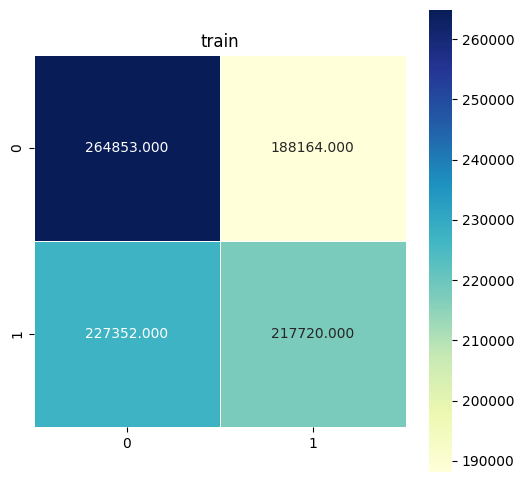

In [21]:

plt.figure(figsize = (6, 6));
sns.heatmap(conf_train, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title("train")

Now I test the function and  get a first results. 

(<AxesSubplot:title={'center':'test'}>, Text(0.5, 1.0, 'test'))

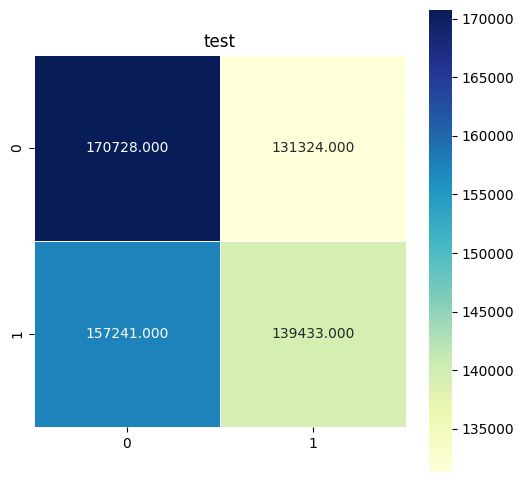

In [22]:

plt.figure(figsize = (6, 6));
sns.heatmap(conf_test, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title("test")

Prediction is not good, likely a sign that it is not a good idea to train on winning for the original data set were there is a lot of randomness. 

In [24]:
for i in range(1,9):
    loop_reg(feature_train,target_train, feature_test,target_test,i,0.1,1.414,30,'take_open_random_xgb_depth'+str(i)+'.txt',False)

doing case 0
xgb took 7.9256 seconds
percentage wrong test 48.06
percentage wrong train 47.98 
doing case 1
xgb took 7.5481 seconds
percentage wrong test 48.06
percentage wrong train 47.98 
doing case 2
xgb took 7.2886 seconds
percentage wrong test 48.06
percentage wrong train 47.98 
doing case 3
xgb took 7.3348 seconds
percentage wrong test 48.06
percentage wrong train 47.98 
doing case 4
xgb took 7.3584 seconds
percentage wrong test 48.06
percentage wrong train 47.98 
doing case 5
xgb took 7.3889 seconds
percentage wrong test 48.06
percentage wrong train 47.98 
doing case 6
xgb took 7.049 seconds
percentage wrong test 48.06
percentage wrong train 47.98 
doing case 7
xgb took 7.1155 seconds
percentage wrong test 48.06
percentage wrong train 47.98 
doing case 8
xgb took 7.4921 seconds
percentage wrong test 48.06
percentage wrong train 47.98 
doing case 9
xgb took 7.5057 seconds
percentage wrong test 48.06
percentage wrong train 47.97 
doing case 10
xgb took 7.6799 seconds
percentage wr

xgb took 10.4086 seconds
percentage wrong test 48.09
percentage wrong train 48.02 
doing case 27
xgb took 10.2513 seconds
percentage wrong test 48.09
percentage wrong train 48.03 
doing case 28
xgb took 10.1211 seconds
percentage wrong test 48.1
percentage wrong train 48.02 
doing case 29
xgb took 10.0244 seconds
percentage wrong test 48.13
percentage wrong train 48.02 
doing case 0
xgb took 27.5782 seconds
percentage wrong test 48.07
percentage wrong train 47.26 
doing case 1
xgb took 27.5415 seconds
percentage wrong test 48.05
percentage wrong train 47.29 
doing case 2
xgb took 27.3073 seconds
percentage wrong test 48.06
percentage wrong train 47.29 
doing case 3
xgb took 27.2318 seconds
percentage wrong test 48.03
percentage wrong train 47.28 
doing case 4
xgb took 27.227 seconds
percentage wrong test 48.05
percentage wrong train 47.24 
doing case 5
xgb took 27.2208 seconds
percentage wrong test 48.09
percentage wrong train 47.21 
doing case 6
xgb took 27.3426 seconds
percentage wro

percentage wrong test 47.99
percentage wrong train 47.66 
doing case 22
xgb took 22.215 seconds
percentage wrong test 47.99
percentage wrong train 47.75 
doing case 23
xgb took 22.5353 seconds
percentage wrong test 47.99
percentage wrong train 47.84 
doing case 24
xgb took 21.514 seconds
percentage wrong test 48.06
percentage wrong train 47.89 
doing case 25
xgb took 19.7814 seconds
percentage wrong test 48.06
percentage wrong train 47.95 
doing case 26
xgb took 18.2429 seconds
percentage wrong test 48.08
percentage wrong train 47.96 
doing case 27
xgb took 19.1746 seconds
percentage wrong test 48.1
percentage wrong train 47.97 
doing case 28
xgb took 18.6579 seconds
percentage wrong test 48.11
percentage wrong train 47.99 
doing case 29
xgb took 17.8326 seconds
percentage wrong test 48.12
percentage wrong train 48.0 
doing case 0
xgb took 66.7908 seconds
percentage wrong test 48.23
percentage wrong train 45.38 
doing case 1
xgb took 66.4174 seconds
percentage wrong test 48.31
percenta

In [28]:
tran1=np.loadtxt("take_open_random_xgb_depth1.txt")
tran2=np.loadtxt("take_open_random_xgb_depth2.txt")
tran3=np.loadtxt("take_open_random_xgb_depth3.txt")
tran4=np.loadtxt("take_open_random_xgb_depth4.txt")
tran5=np.loadtxt("take_open_random_xgb_depth5.txt")
tran6=np.loadtxt("take_open_random_xgb_depth6.txt")
tran7=np.loadtxt("take_open_random_xgb_depth7.txt")
tran8=np.loadtxt("take_open_random_xgb_depth8.txt")

print(f"minimum percent wrong of (prediction-test data) {round(min(100*tran1[3]),4)} % of max-depth=1")
print(f"minimum percent wrong of (prediction-test data) {round(min(100*tran2[3]),4)} % of max-depth=2")
print(f"minimum percent wrong of (prediction-test data) {round(min(100*tran3[3]),4)} % of max-depth=3")
print(f"minimum percent wrong of (prediction-test data) {round(min(100*tran4[3]),4)} % of max-depth=4")

print(f"minimum percent wrong of (prediction-test data) {round(min(100*tran5[3]),4)} % of max-depth=5")
print(f"minimum percent wrong of (prediction-test data) {round(min(100*tran6[3]),4)} % of max-depth=6")
print(f"minimum percent wrong of (prediction-test data) {round(min(100*tran7[3]),4)} % of max-depth=7")
print(f"minimum percent wrong of (prediction-test data) {round(min(100*tran8[3]),4)} % of max-depth=8")

minimum percent wrong of (prediction-test data) 48.0564 % of max-depth=1
minimum percent wrong of (prediction-test data) 48.0044 % of max-depth=2
minimum percent wrong of (prediction-test data) 47.9912 % of max-depth=3
minimum percent wrong of (prediction-test data) 47.9862 % of max-depth=4
minimum percent wrong of (prediction-test data) 47.978 % of max-depth=5
minimum percent wrong of (prediction-test data) 47.9857 % of max-depth=6
minimum percent wrong of (prediction-test data) 48.0033 % of max-depth=7
minimum percent wrong of (prediction-test data) 47.9657 % of max-depth=8


The regularization of the small % wrong is 204.12068079166409


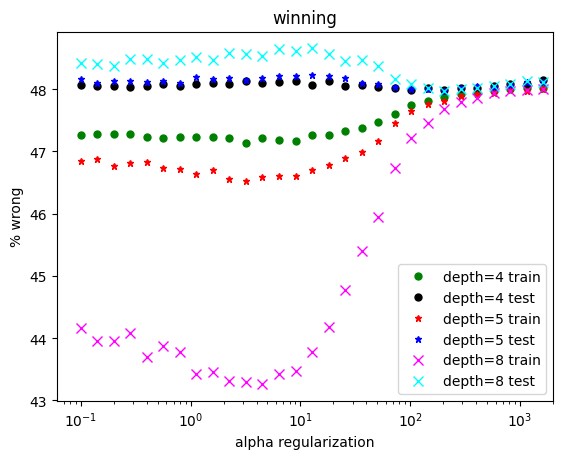

In [34]:
plt.plot(tran4[0,:],100*tran4[2,:],'o',ms=5,color='green',label='depth=4 train') 
plt.plot(tran4[0,:],100*tran4[3,:],'o',ms=5,color='black',label='depth=4 test') 
plt.plot(tran5[0,:],100*tran5[2,:],'*',ms=5,color='red',label='depth=5 train') 
plt.plot(tran5[0,:],100*tran5[3,:],'*',ms=5,color='blue',label='depth=5 test') 
plt.plot(tran8[0,:],100*tran8[2,:],'x',ms=7,color='magenta',label='depth=8 train') 
plt.plot(tran8[0,:],100*tran8[3,:],'x',ms=7,color='cyan',label='depth=8 test') 
plt.legend(loc="best")
plt.xscale('log')
plt.xlim(0,2000)
#plt.ylim(0,10)
plt.xlabel("alpha regularization")
plt.title("winning slected take open True/False")
plt.ylabel("% wrong")
print(f"The regularization of the small % wrong is {tran8[0,np.argmin(tran8[3])]}") 

Has real minimum in test which has similar metric as train, but the improvement is small compared to flat, thus not clear whether it works. Also is slow, thus I will wait with the next part until later. 

In [36]:

regxl29=XGBClassifier(max_depth=8,reg_alpha=204.12068079166409).fit(df_win_sel.iloc[:,0:9],df_win_sel.iloc[:,9])
#and save it
#regxl29.save_model("xgb_model_open_ran1.json")



Text(0, 0.5, 'feature importance')

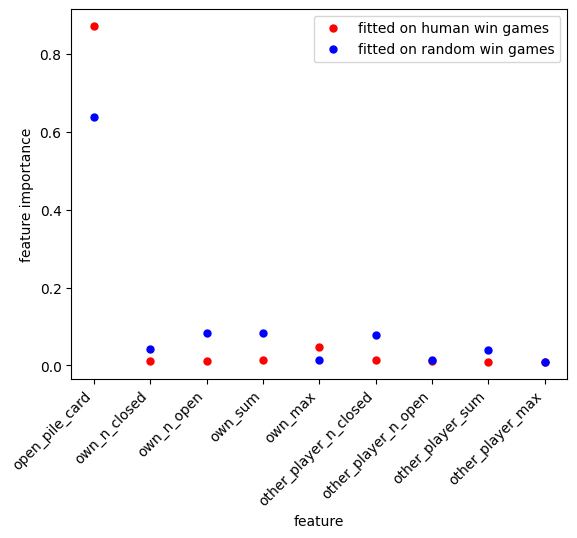

In [38]:
regxl30=XGBClassifier()
regxl30.load_model("xgb_open_win1.json")
regxl29=XGBClassifier()
regxl29.load_model("xgb_model_open_ran1.json")
plt.plot(feature_train.columns,regxl30.feature_importances_,'o',ms=5,color='red',label='fitted on human win games') 
plt.plot(feature_train.columns,regxl29.feature_importances_,'o',ms=5,color='blue',label='fitted on random win games') 
plt.legend(loc="best")
#plt.xscale("log")
#plt.ylim(55,65)
plt.xticks(rotation=45, ha='right')
plt.title("take open True/False")
plt.xlabel("feature")
plt.ylabel("feature importance")

There is similarity, the most important feature for both is open_pile_card. The rest is different but is not so important for both. 

Now doing the same for discard or keep closed card. When the open card is used this row is excluded. 

In [16]:
df_win_discard_sel=df_win_discard.loc[:,col_sel2]
print(df_win_discard_sel.shape)

(755069, 11)


In [17]:
feature_train_discard,feature_test_discard,target_train_discard,target_test_discard=split_test_valid(df_win_discard_sel.iloc[:,0:10],df_win_discard_sel.iloc[:,10],0.6)
print(feature_train_discard.shape,feature_test_discard.shape,target_test_discard.shape,feature_train_discard.head())

453041
(453041, 10) (302028, 10) (302028,)     open_pile_card  own_n_closed  own_n_open  own_sum  own_max  \
1                0             1          11     36.0     11.0   
4                4             2          10     28.0      9.0   
11               2             8           4     18.0      7.0   
15               6             3           9     53.0     12.0   
20               3             7           5     28.0     10.0   

    other_player_n_closed  other_player_n_open  other_player_sum  \
1                       4                    8              30.0   
4                       1                   11              63.0   
11                      8                    4              19.0   
15                      2                    7              31.0   
20                      8                    4              17.0   

    other_player_max  discard_value  
1                9.0             12  
4               12.0             10  
11               9.0             12  

In [27]:
for i in range(1,6):
    loop_reg(feature_train_discard,target_train_discard, feature_test_discard,target_test_discard,i,0.1,1.414,30,'take_discard_random_xgb_depth'+str(i)+'.txt',False)

doing case 0
xgb took 3.2819 seconds
percentage wrong test 46.86
percentage wrong train 46.84 
doing case 1
xgb took 3.2405 seconds
percentage wrong test 46.86
percentage wrong train 46.84 
doing case 2
xgb took 3.0825 seconds
percentage wrong test 46.86
percentage wrong train 46.84 
doing case 3
xgb took 3.0771 seconds
percentage wrong test 46.86
percentage wrong train 46.83 
doing case 4
xgb took 3.1029 seconds
percentage wrong test 46.87
percentage wrong train 46.85 
doing case 5
xgb took 3.0907 seconds
percentage wrong test 46.87
percentage wrong train 46.85 
doing case 6
xgb took 3.1368 seconds
percentage wrong test 46.86
percentage wrong train 46.84 
doing case 7
xgb took 3.1303 seconds
percentage wrong test 46.86
percentage wrong train 46.84 
doing case 8
xgb took 3.0857 seconds
percentage wrong test 46.85
percentage wrong train 46.84 
doing case 9
xgb took 3.1547 seconds
percentage wrong test 46.86
percentage wrong train 46.84 
doing case 10
xgb took 3.1493 seconds
percentage w

xgb took 4.7437 seconds
percentage wrong test 47.01
percentage wrong train 46.91 
doing case 27
xgb took 4.5519 seconds
percentage wrong test 47.01
percentage wrong train 46.92 
doing case 28
xgb took 4.4702 seconds
percentage wrong test 47.07
percentage wrong train 46.93 
doing case 29
xgb took 4.4417 seconds
percentage wrong test 47.15
percentage wrong train 47.03 
doing case 0
xgb took 12.1479 seconds
percentage wrong test 46.99
percentage wrong train 45.63 
doing case 1
xgb took 12.2739 seconds
percentage wrong test 46.94
percentage wrong train 45.69 
doing case 2
xgb took 12.2044 seconds
percentage wrong test 46.99
percentage wrong train 45.7 
doing case 3
xgb took 12.2461 seconds
percentage wrong test 47.01
percentage wrong train 45.67 
doing case 4
xgb took 12.1318 seconds
percentage wrong test 46.87
percentage wrong train 45.62 
doing case 5
xgb took 12.1488 seconds
percentage wrong test 46.95
percentage wrong train 45.65 
doing case 6
xgb took 12.1624 seconds
percentage wrong 

In [28]:
dran1=np.loadtxt("take_discard_random_xgb_depth1.txt")
dran2=np.loadtxt("take_discard_random_xgb_depth2.txt")
dran3=np.loadtxt("take_discard_random_xgb_depth3.txt")
dran4=np.loadtxt("take_discard_random_xgb_depth4.txt")
dran5=np.loadtxt("take_discard_random_xgb_depth5.txt")
dran6=np.loadtxt("take_discard_random_xgb_depth6.txt")
dran7=np.loadtxt("take_discard_random_xgb_depth7.txt")
dran8=np.loadtxt("take_discard_random_xgb_depth8.txt")

print(f"minimum percent wrong of (prediction-test data) {round(min(100*dran1[3]),4)} % of max-depth=1")
print(f"minimum percent wrong of (prediction-test data) {round(min(100*dran2[3]),4)} % of max-depth=2")
print(f"minimum percent wrong of (prediction-test data) {round(min(100*dran3[3]),4)} % of max-depth=3")
print(f"minimum percent wrong of (prediction-test data) {round(min(100*dran4[3]),4)} % of max-depth=4")

print(f"minimum percent wrong of (prediction-test data) {round(min(100*dran5[3]),4)} % of max-depth=5")
print(f"minimum percent wrong of (prediction-test data) {round(min(100*dran6[3]),4)} % of max-depth=6")
print(f"minimum percent wrong of (prediction-test data) {round(min(100*dran7[3]),4)} % of max-depth=7")
print(f"minimum percent wrong of (prediction-test data) {round(min(100*dran8[3]),4)} % of max-depth=8")

minimum percent wrong of (prediction-test data) 46.8529 % of max-depth=1
minimum percent wrong of (prediction-test data) 46.7195 % of max-depth=2
minimum percent wrong of (prediction-test data) 46.7271 % of max-depth=3
minimum percent wrong of (prediction-test data) 46.7559 % of max-depth=4
minimum percent wrong of (prediction-test data) 46.7102 % of max-depth=5
minimum percent wrong of (prediction-test data) 46.7294 % of max-depth=6
minimum percent wrong of (prediction-test data) 46.7354 % of max-depth=7
minimum percent wrong of (prediction-test data) 46.745 % of max-depth=8


The regularization of the small % wrong is 144.35691710867334


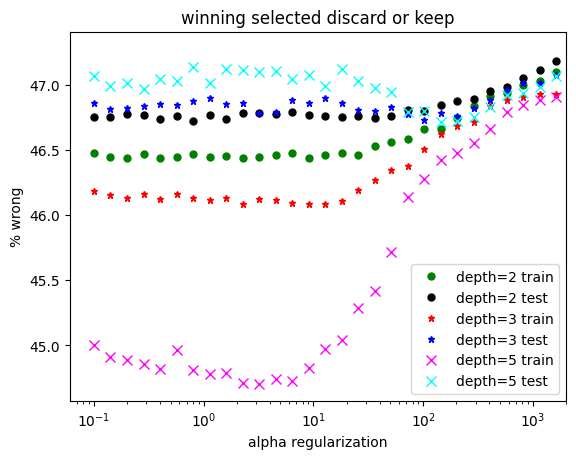

In [29]:
plt.plot(dran2[0,:],100*dran2[2,:],'o',ms=5,color='green',label='depth=2 train') 
plt.plot(dran2[0,:],100*dran2[3,:],'o',ms=5,color='black',label='depth=2 test') 
plt.plot(dran3[0,:],100*dran3[2,:],'*',ms=5,color='red',label='depth=3 train') 
plt.plot(dran3[0,:],100*dran3[3,:],'*',ms=5,color='blue',label='depth=3 test') 
plt.plot(dran5[0,:],100*dran5[2,:],'x',ms=7,color='magenta',label='depth=5 train') 
plt.plot(dran5[0,:],100*dran5[3,:],'x',ms=7,color='cyan',label='depth=5 test') 
plt.legend(loc="best")
plt.xscale('log')
plt.xlim(0,2000)
#plt.ylim(0,10)
plt.xlabel("alpha regularization")
plt.title("winning selected discard or keep")
plt.ylabel("% wrong")
print(f"The regularization of the smallest % wrong is {dran5[0,np.argmin(dran5[3])]}") 

In [30]:

regxl31=XGBClassifier(max_depth=5,reg_alpha=144.35691710867334).fit(df_win_discard_sel.iloc[:,0:10],df_win_discard_sel.iloc[:,10])
#and save it
#regxl31.save_model("xgb_model_discard_ran1.json")

Text(0, 0.5, 'feature importance')

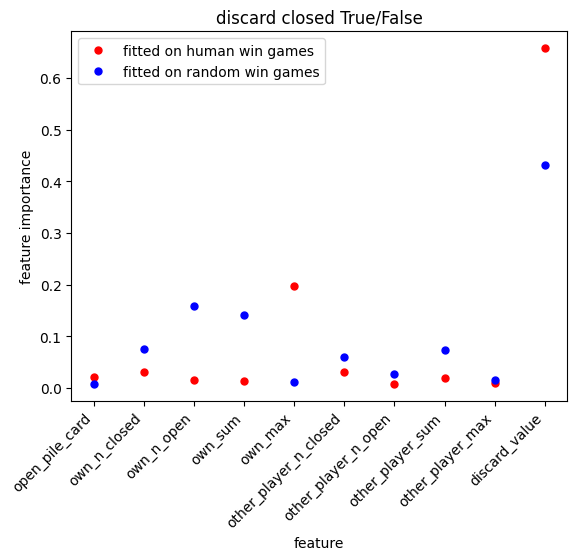

In [31]:
regxl32=XGBClassifier()
regxl32.load_model("xgb_discard_win1.json")
regxl31=XGBClassifier()
regxl31.load_model("xgb_model_discard_ran1.json")
plt.plot(feature_train_discard.columns,regxl32.feature_importances_,'o',ms=5,color='red',label='fitted on human win games') 
plt.plot(feature_train_discard.columns,regxl31.feature_importances_,'o',ms=5,color='blue',label='fitted on random win games') 
plt.legend(loc="best")
#plt.xscale("log")
#plt.ylim(55,65)
plt.xticks(rotation=45, ha='right')
plt.title("discard closed True/False")
plt.xlabel("feature")
plt.ylabel("feature importance")

Now for the value card column selection. Also the same as before in the human games. 

In [32]:
df_win_value=df[ (df.score_self<df.score_other) & (df.action_discard==0)]

In [35]:
df_win_value_sel=df_win_value.loc[:,col_sel3]
print(df_win_value_sel.shape,df_win_value_sel.columns)

(1113061, 12) Index(['open_pile_card', 'own_n_closed', 'own_n_open', 'own_sum', 'own_max',
       'other_player_n_closed', 'other_player_n_open', 'other_player_sum',
       'other_player_max', 'action_take_open', 'discard_value',
       'value_player_card'],
      dtype='object')


In [36]:
feature_train_value,feature_test_value,target_train_value,target_test_value=split_test_valid(df_win_value_sel.iloc[:,0:11],df_win_value_sel.iloc[:,11],0.6)
print(feature_train_value.shape,feature_test_value.shape,target_test_value.shape,feature_train_value.head())

667837
(667837, 11) (445224, 11) (445224,)     open_pile_card  own_n_closed  own_n_open  own_sum  own_max  \
5                5             7           5     31.0     12.0   
7               12             3           9     42.0     12.0   
8                1             4           8     38.0      9.0   
10               0            10           2     21.0     11.0   
11               2             8           4     18.0      7.0   

    other_player_n_closed  other_player_n_open  other_player_sum  \
5                       7                    5              35.0   
7                       3                    9              59.0   
8                       7                    5              14.0   
10                     10                    2              15.0   
11                      8                    4              19.0   

    other_player_max  action_take_open  discard_value  
5               11.0                 1             30  
7               12.0                 1 

In [44]:
for i in range(1,9):
    loop_reg(feature_train_value,target_train_value, feature_test_value,target_test_value,i,1,1.414,30,'value_random_xgb_depth'+str(i)+'.txt',True)

doing case 0
xgb took 5.3844 seconds
standard deviation of test 3.1888 points
standard deviation of train 3.1899  points
standard deviation of prediction-test 3.0379 points
standard deviation of prediction-train 3.0369 points
doing case 1
xgb took 5.3028 seconds
standard deviation of test 3.1888 points
standard deviation of train 3.1899  points
standard deviation of prediction-test 3.0379 points
standard deviation of prediction-train 3.0369 points
doing case 2
xgb took 5.3566 seconds
standard deviation of test 3.1888 points
standard deviation of train 3.1899  points
standard deviation of prediction-test 3.0379 points
standard deviation of prediction-train 3.0369 points
doing case 3
xgb took 5.4223 seconds
standard deviation of test 3.1888 points
standard deviation of train 3.1899  points
standard deviation of prediction-test 3.0379 points
standard deviation of prediction-train 3.0369 points
doing case 4
xgb took 5.2931 seconds
standard deviation of test 3.1888 points
standard deviation

xgb took 11.8459 seconds
standard deviation of test 3.1888 points
standard deviation of train 3.1899  points
standard deviation of prediction-test 3.0291 points
standard deviation of prediction-train 3.0263 points
doing case 8
xgb took 13.8359 seconds
standard deviation of test 3.1888 points
standard deviation of train 3.1899  points
standard deviation of prediction-test 3.0292 points
standard deviation of prediction-train 3.0265 points
doing case 9
xgb took 12.9633 seconds
standard deviation of test 3.1888 points
standard deviation of train 3.1899  points
standard deviation of prediction-test 3.0292 points
standard deviation of prediction-train 3.0265 points
doing case 10
xgb took 13.4454 seconds
standard deviation of test 3.1888 points
standard deviation of train 3.1899  points
standard deviation of prediction-test 3.0292 points
standard deviation of prediction-train 3.0263 points
doing case 11
xgb took 15.8693 seconds
standard deviation of test 3.1888 points
standard deviation of tr

standard deviation of test 3.1888 points
standard deviation of train 3.1899  points
standard deviation of prediction-test 3.0277 points
standard deviation of prediction-train 3.0234 points
doing case 14
xgb took 16.5514 seconds
standard deviation of test 3.1888 points
standard deviation of train 3.1899  points
standard deviation of prediction-test 3.0279 points
standard deviation of prediction-train 3.0236 points
doing case 15
xgb took 16.4401 seconds
standard deviation of test 3.1888 points
standard deviation of train 3.1899  points
standard deviation of prediction-test 3.0276 points
standard deviation of prediction-train 3.0234 points
doing case 16
xgb took 16.7241 seconds
standard deviation of test 3.1888 points
standard deviation of train 3.1899  points
standard deviation of prediction-test 3.0276 points
standard deviation of prediction-train 3.0236 points
doing case 17
xgb took 16.8162 seconds
standard deviation of test 3.1888 points
standard deviation of train 3.1899  points
stan

xgb took 22.8932 seconds
standard deviation of test 3.1888 points
standard deviation of train 3.1899  points
standard deviation of prediction-test 3.029 points
standard deviation of prediction-train 3.0249 points
doing case 21
xgb took 22.884 seconds
standard deviation of test 3.1888 points
standard deviation of train 3.1899  points
standard deviation of prediction-test 3.0288 points
standard deviation of prediction-train 3.0256 points
doing case 22
xgb took 22.7759 seconds
standard deviation of test 3.1888 points
standard deviation of train 3.1899  points
standard deviation of prediction-test 3.0295 points
standard deviation of prediction-train 3.0267 points
doing case 23
xgb took 19.4307 seconds
standard deviation of test 3.1888 points
standard deviation of train 3.1899  points
standard deviation of prediction-test 3.0303 points
standard deviation of prediction-train 3.028 points
doing case 24
xgb took 19.5384 seconds
standard deviation of test 3.1888 points
standard deviation of tra

standard deviation of test 3.1888 points
standard deviation of train 3.1899  points
standard deviation of prediction-test 3.0352 points
standard deviation of prediction-train 3.0335 points
doing case 27
xgb took 16.1017 seconds
standard deviation of test 3.1888 points
standard deviation of train 3.1899  points
standard deviation of prediction-test 3.0382 points
standard deviation of prediction-train 3.0369 points
doing case 28
xgb took 15.0747 seconds
standard deviation of test 3.1888 points
standard deviation of train 3.1899  points
standard deviation of prediction-test 3.0423 points
standard deviation of prediction-train 3.0417 points
doing case 29
xgb took 14.1673 seconds
standard deviation of test 3.1888 points
standard deviation of train 3.1899  points
standard deviation of prediction-test 3.0478 points
standard deviation of prediction-train 3.0473 points
doing case 0
xgb took 34.0752 seconds
standard deviation of test 3.1888 points
standard deviation of train 3.1899  points
stand

xgb took 39.1396 seconds
standard deviation of test 3.1888 points
standard deviation of train 3.1899  points
standard deviation of prediction-test 3.035 points
standard deviation of prediction-train 2.9845 points
doing case 4
xgb took 40.7466 seconds
standard deviation of test 3.1888 points
standard deviation of train 3.1899  points
standard deviation of prediction-test 3.035 points
standard deviation of prediction-train 2.9844 points
doing case 5
xgb took 38.8554 seconds
standard deviation of test 3.1888 points
standard deviation of train 3.1899  points
standard deviation of prediction-test 3.0351 points
standard deviation of prediction-train 2.986 points
doing case 6
xgb took 38.042 seconds
standard deviation of test 3.1888 points
standard deviation of train 3.1899  points
standard deviation of prediction-test 3.0353 points
standard deviation of prediction-train 2.9847 points
doing case 7
xgb took 43.0863 seconds
standard deviation of test 3.1888 points
standard deviation of train 3.

standard deviation of test 3.1888 points
standard deviation of train 3.1899  points
standard deviation of prediction-test 3.0386 points
standard deviation of prediction-train 2.9683 points
doing case 10
xgb took 61.8732 seconds
standard deviation of test 3.1888 points
standard deviation of train 3.1899  points
standard deviation of prediction-test 3.0383 points
standard deviation of prediction-train 2.9697 points
doing case 11
xgb took 51.7176 seconds
standard deviation of test 3.1888 points
standard deviation of train 3.1899  points
standard deviation of prediction-test 3.0364 points
standard deviation of prediction-train 2.9764 points
doing case 12
xgb took 47.9293 seconds
standard deviation of test 3.1888 points
standard deviation of train 3.1899  points
standard deviation of prediction-test 3.0359 points
standard deviation of prediction-train 2.982 points
doing case 13
xgb took 45.5799 seconds
standard deviation of test 3.1888 points
standard deviation of train 3.1899  points
stand

In [47]:
vran1=np.loadtxt("value_random_xgb_depth1.txt")
vran2=np.loadtxt("value_random_xgb_depth2.txt")
vran3=np.loadtxt("value_random_xgb_depth3.txt")
vran4=np.loadtxt("value_random_xgb_depth4.txt")
vran5=np.loadtxt("value_random_xgb_depth5.txt")
vran6=np.loadtxt("value_random_xgb_depth6.txt")
vran7=np.loadtxt("value_random_xgb_depth7.txt")
vran8=np.loadtxt("value_random_xgb_depth8.txt")

print(f"minimum standard deviation of (prediction-test data) {round(min(vran1[3]),5)} % of max-depth=1")
print(f"minimum standard deviation of (prediction-test data) {round(min(vran2[3]),5)} % of max-depth=2")
print(f"minimum standard deviation of (prediction-test data) {round(min(vran3[3]),5)} % of max-depth=3")
print(f"minimum standard deviation of (prediction-test data) {round(min(vran4[3]),5)} % of max-depth=4")
print(f"minimum standard deviation of (prediction-test data) {round(min(vran5[3]),5)} % of max-depth=5")
print(f"minimum standard deviation of (prediction-test data) {round(min(vran6[3]),5)} % of max-depth=6")
print(f"minimum standard deviation of (prediction-test data) {round(min(vran7[3]),5)} % of max-depth=7")
print(f"minimum standard deviation of (prediction-test data) {round(min(vran8[3]),5)} % of max-depth=8")

minimum standard deviation of (prediction-test data) 3.03786 % of max-depth=1
minimum standard deviation of (prediction-test data) 3.02899 % of max-depth=2
minimum standard deviation of (prediction-test data) 3.02742 % of max-depth=3
minimum standard deviation of (prediction-test data) 3.02753 % of max-depth=4
minimum standard deviation of (prediction-test data) 3.02803 % of max-depth=5
minimum standard deviation of (prediction-test data) 3.02837 % of max-depth=6
minimum standard deviation of (prediction-test data) 3.02863 % of max-depth=7
minimum standard deviation of (prediction-test data) 3.02872 % of max-depth=8


The regularization of the smallest standard deviation is 63.88411952059212


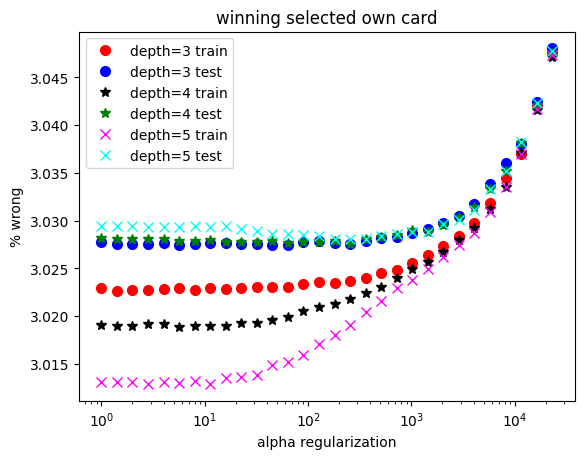

In [52]:
plt.plot(vran3[0,:],vran3[2,:],'o',ms=7,color='red',label='depth=3 train') 
plt.plot(vran3[0,:],vran3[3,:],'o',ms=7,color='blue',label='depth=3 test')
plt.plot(vran4[0,:],vran4[2,:],'*',ms=7,color='black',label='depth=4 train') 
plt.plot(vran4[0,:],vran4[3,:],'*',ms=7,color='green',label='depth=4 test')
plt.plot(vran5[0,:],vran5[2,:],'x',ms=7,color='magenta',label='depth=5 train') 
plt.plot(vran5[0,:],vran5[3,:],'x',ms=7,color='cyan',label='depth=5 test') 
plt.legend(loc="best")
plt.xscale('log')
#plt.xlim(0,2000)
#plt.ylim(0,10)
plt.xlabel("alpha regularization")
plt.title("winning selected own card")
plt.ylabel("% wrong")
print(f"The regularization of the smallest standard deviation is {vran3[0,np.argmin(vran3[3])]}") 

In [49]:

regxl33=XGBRegressor(max_depth=3,reg_alpha=63.88411952059212).fit(df_win_value_sel.iloc[:,0:11],df_win_value_sel.iloc[:,11])
#and save it and avoid that it is overwritten
#regxl33.save_model("xgb_model_value_ran1.json")

Text(0, 0.5, 'feature importance')

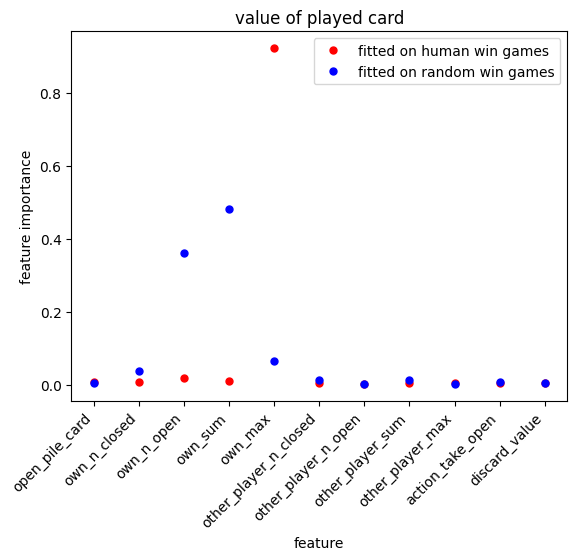

In [43]:
regxl34=XGBRegressor()
regxl34.load_model("xgb_value_win1.json")
regxl33=XGBRegressor()
regxl33.load_model("xgb_model_value_ran1.json")
plt.plot(feature_train_value.columns,regxl34.feature_importances_,'o',ms=5,color='red',label='fitted on human win games') 
plt.plot(feature_train_value.columns,regxl33.feature_importances_,'o',ms=5,color='blue',label='fitted on random win games') 
plt.legend(loc="best")
#plt.xscale("log")
#plt.ylim(55,65)
plt.xticks(rotation=45, ha='right')
plt.title("value of played card")
plt.xlabel("feature")
plt.ylabel("feature importance")

The importance looks here different, but that is no surprising. I know that at least I are mostly concentrating on the largest value because it can be easier assest by humans. 
In reality it is likely that the number of open cards and their value is more important to decide who wins. 